In [1]:
from datasets import load_dataset

# Load the ner_movie dataset
dataset = load_dataset("ttxy/ner_movie")

# View a sample from the training split
print(dataset["train"][0])


c:\Users\ANVESH\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'text': 'steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies', 'label': 'B-Actor,I-Actor,O,O,B-Plot,I-Plot,I-Plot,I-Plot,I-Plot,B-Opinion,I-Opinion,I-Opinion,B-Plot,I-Plot,I-Plot,I-Plot,I-Plot'}


In [2]:
train_data = dataset["train"]
import re

# Prepare sentences and labels
texts = [sample['text'] for sample in train_data]
sentences_train=[text.split() for text in texts]

tags= [sample['label'] for sample in train_data]
labels_train= [re.findall(r'\b[\w-]+\b', text) for text in tags]

# Print a sample
print("Sample sentence:", sentences_train[0],len(sentences_train[0]),len(sentences_train))

print("Sample labels:", labels_train[0],len(labels_train[0]),len(labels_train))

Sample sentence: ['steve', 'mcqueen', 'provided', 'a', 'thrilling', 'motorcycle', 'chase', 'in', 'this', 'greatest', 'of', 'all', 'ww', '2', 'prison', 'escape', 'movies'] 17 7816
Sample labels: ['B-Actor', 'I-Actor', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'B-Opinion', 'I-Opinion', 'I-Opinion', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot'] 17 7816


In [3]:
unique_labels_train = set(label for sublist in labels_train for label in sublist)
print(len(unique_labels_train),unique_labels_train)

25 {'B-Year', 'I-Year', 'I-Soundtrack', 'B-Director', 'B-Opinion', 'I-Plot', 'B-Soundtrack', 'B-Genre', 'I-Origin', 'B-Plot', 'I-Award', 'B-Award', 'B-Actor', 'O', 'I-Opinion', 'I-Actor', 'B-Origin', 'I-Character_Name', 'I-Relationship', 'B-Quote', 'I-Director', 'I-Quote', 'I-Genre', 'B-Relationship', 'B-Character_Name'}


In [4]:
# GNN for NER using BIO tagging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import spacy
from transformers import BertTokenizer, BertModel




label_to_index = {label: idx for idx, label in enumerate(sorted(unique_labels_train))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
num_classes = len(label_to_index)
print(len(unique_labels_train),label_to_index["I-Quote"])



25 20


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import spacy
from transformers import BertTokenizer, BertModel


nlp=spacy.load("en_core_web_sm")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
from collections import defaultdict

def make_unique_tokens(tokens):
    word_counts = defaultdict(int)
    unique_tokens = []
    for word in tokens:
        word_counts[word] += 1
        unique_tokens.append(f"{word}_{word_counts[word]}")
    return unique_tokens

In [7]:
def build_graph_from_spacy(unique_sentence):
    doc = nlp(unique_sentence)
    edge_index = [[], []]
    for token in doc:
        if token.head != token:
            edge_index[0].append(token.i)
            edge_index[1].append(token.head.i)
            edge_index[0].append(token.head.i)
            edge_index[1].append(token.i)
    return doc, edge_index


In [8]:
def extract_bert_embeddings(original_tokens):
    inputs = tokenizer(original_tokens, return_tensors='pt', is_split_into_words=True, padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state[0]  # shape: [num_tokens, 768]

    # Filter out special tokens and subwords
    x_clean = []
    for idx, token in enumerate(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])):
        if token in ['[CLS]', '[SEP]'] or token.startswith('##'):
            continue
        x_clean.append(embeddings[idx])
    return torch.stack(x_clean)  # shape: [num_original_tokens, 768]


## dataset prep

In [10]:
from collections import defaultdict
import torch
from torch_geometric.data import Data

def process_sentence(tokens, labels):
    # Step 1: Run SpaCy on original sentence
    sentence = ' '.join(tokens)
    doc = nlp(sentence)

    # Step 2: Create unique names for graph nodes (renamed_tokens)
    word_counts = defaultdict(int)
    renamed_tokens = []
    for tok in tokens:
        word_counts[tok] += 1
        renamed_tokens.append(f"{tok}_{word_counts[tok]}")

    # Step 3: Build mapping from SpaCy token index to renamed token
    idx_to_node = {i: renamed_tokens[i] for i in range(len(tokens))}

    # Step 4: Create edge list using SpaCy dependencies
    edge_index = [[], []]
    for token in doc:
        if token.i < len(tokens) and token.head.i < len(tokens) and token.i != token.head.i:
            edge_index[0].append(token.i)
            edge_index[1].append(token.head.i)
            edge_index[0].append(token.head.i)
            edge_index[1].append(token.i)

    num_nodes = len(tokens)

    # Step 5: Get BERT embeddings for original tokens
    inputs = tokenizer(tokens, return_tensors='pt', is_split_into_words=True, padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state[0]  # shape: [seq_len, hidden_size]
    tokenized_ids = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Step 6: Filter BERT tokens ([CLS], [SEP], and subwords)
    x_clean = []
    idx = 0
    for tok in tokenized_ids:
        if tok in ['[CLS]', '[SEP]']:
            idx += 1
            continue
        if tok.startswith('##'):
            idx += 1
            continue
        x_clean.append(embeddings[idx])
        idx += 1

    x_clean = torch.stack(x_clean)  # shape: [num_tokens, 768]
    y = torch.tensor([label_to_index[label] for label in labels], dtype=torch.long)

    # Step 7: Add self-loops if no edges, and as general enhancement
    if not edge_index[0]:
        edge_index = [list(range(num_nodes)), list(range(num_nodes))]
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    self_loops = torch.arange(num_nodes).unsqueeze(0).repeat(2, 1)
    edge_index = torch.cat([edge_index, self_loops], dim=1)

    # Step 8: Final sanity checks
    assert x_clean.shape[0] == num_nodes, f"Mismatch: {x_clean.shape[0]} embeddings but {num_nodes} nodes"
    assert len(y) == num_nodes, f"Mismatch: {len(y)} labels but {num_nodes} nodes"

    return Data(x=x_clean, edge_index=edge_index, y=y)


In [12]:
graph_data_list = [process_sentence(tokens, label_seq) for tokens, label_seq in zip(sentences_train, labels_train)]
ls=[index_to_label[int(x)] for x in graph_data_list[0].y]
print(graph_data_list[0].x,ls)

tensor([[ 0.3520,  0.0706, -0.2636,  ..., -0.1070,  0.3135, -0.3130],
        [ 0.9976, -0.0293, -0.3141,  ..., -0.4966,  0.8210,  0.1055],
        [-0.0314,  0.1850, -0.3448,  ...,  0.1373,  0.2307, -0.1180],
        ...,
        [ 0.1413, -0.5032,  0.0902,  ...,  0.5102, -0.4605, -0.0506],
        [ 0.5626, -0.1377,  0.0810,  ...,  0.5915,  0.1355,  0.0766],
        [ 0.0831,  0.1443, -0.7835,  ...,  0.4704,  0.2926,  0.1960]]) ['B-Actor', 'I-Actor', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'B-Opinion', 'I-Opinion', 'I-Opinion', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot']


In [13]:
from sklearn.model_selection import train_test_split

train_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
print(f"Training graphs: {len(train_graphs)} | Testing graphs: {len(test_graphs)}")


Training graphs: 6252 | Testing graphs: 1564


## dataset loading

In [14]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)


## model and training

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNTagger(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes):
        super(GCNTagger, self).__init__()
        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.gcn2(x, edge_index)
        logits = self.classifier(x)  # [num_nodes, num_classes]
        return logits



In [19]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        out = model(batch)            # [num_nodes, num_classes]
        loss = loss_fn(out, batch.y)  # [num_nodes]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            out = model(batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total if total > 0 else 0.0


In [20]:
in_channels = 768
hidden_channels = 128
num_classes = len(label_to_index)

model = GCNTagger(in_channels, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(1, 31):  # 10 epochs
    train_loss = train(model, train_loader, optimizer, loss_fn)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Epoch 01 | Train Loss: 0.7136 | Test Accuracy: 0.7988
Epoch 02 | Train Loss: 0.5954 | Test Accuracy: 0.8236
Epoch 03 | Train Loss: 0.5488 | Test Accuracy: 0.8135
Epoch 04 | Train Loss: 0.5197 | Test Accuracy: 0.8250
Epoch 05 | Train Loss: 0.4966 | Test Accuracy: 0.8082
Epoch 06 | Train Loss: 0.4769 | Test Accuracy: 0.8279
Epoch 07 | Train Loss: 0.4620 | Test Accuracy: 0.8246
Epoch 08 | Train Loss: 0.4416 | Test Accuracy: 0.8276
Epoch 09 | Train Loss: 0.4277 | Test Accuracy: 0.8229
Epoch 10 | Train Loss: 0.4124 | Test Accuracy: 0.8252
Epoch 11 | Train Loss: 0.4015 | Test Accuracy: 0.8256
Epoch 12 | Train Loss: 0.3935 | Test Accuracy: 0.8294
Epoch 13 | Train Loss: 0.3846 | Test Accuracy: 0.8280
Epoch 14 | Train Loss: 0.3725 | Test Accuracy: 0.8245
Epoch 15 | Train Loss: 0.3666 | Test Accuracy: 0.8289
Epoch 16 | Train Loss: 0.3576 | Test Accuracy: 0.8221
Epoch 17 | Train Loss: 0.3503 | Test Accuracy: 0.8254
Epoch 18 | Train Loss: 0.3445 | Test Accuracy: 0.8313
Epoch 19 | Train Loss: 0.336

In [26]:
model.eval()
i=0
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        pred = out.argmax(dim=1)
        print("Predicted labels:", [index_to_label[int(i)] for i in pred])
        print("True labels:", [index_to_label[int(i)] for i in batch.y])
        print('\n')
        if(i>2):
            break
        i+=1


Predicted labels: ['O', 'O', 'B-Year', 'O', 'O', 'B-Plot', 'B-Plot', 'O', 'O', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Origin', 'I-Origin', 'I-Origin', 'I-Origin']
True labels: ['O', 'O', 'B-Year', 'O', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'O', 'O', 'B-Origin', 'I-Origin', 'I-Origin']


Predicted labels: ['B-Actor', 'I-Actor', 'I-Award', 'B-Award', 'B-Award', 'O', 'O', 'O', 'O', 'O', 'B-Year', 'B-Director', 'I-Director', 'B-Director', 'B-Genre']
True labels: ['B-Actor', 'I-Actor', 'O', 'O', 'B-Award', 'O', 'O', 'O', 'O', 'O', 'B-Year', 'B-Director', 'I-Director', 'I-Director', 'B-Genre']


Predicted labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Actor', 'I-Actor', 'O', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot']
True labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Actor', 'I-Actor', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Pl

In [31]:
pip install pytorch-crf

Note: you may need to restart the kernel to use updated packages.


## new model using torch crf

In [36]:
from torch_geometric.nn import GCNConv
import pytorch-crf
import torch.nn as nn
import torch

class GCN_CRF(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_labels):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.gcn2 = GCNConv(hidden_channels, num_labels)
        self.crf = CRF(num_labels, batch_first=True)  # batch_first=True expects [B, T, C]

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.relu(self.gcn1(x, edge_index))
        logits = self.gcn2(x, edge_index)  # [num_nodes, num_labels]

        return logits

    def decode(self, logits, mask):
        return self.crf.decode(logits.unsqueeze(0), mask.unsqueeze(0))[0]
    
    def compute_loss(self, logits, labels, mask):
        return -self.crf(logits.unsqueeze(0), labels.unsqueeze(0), mask=mask.unsqueeze(0), reduction='mean')


SyntaxError: invalid syntax (949834233.py, line 2)

In [ ]:
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        logits = model(batch)  # [num_nodes, num_classes]
        mask = torch.ones_like(batch.y, dtype=torch.bool)
        loss = model.compute_loss(logits, batch.y, mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch)
            mask = torch.ones_like(batch.y, dtype=torch.bool)
            pred = model.decode(logits, mask)
            correct += (torch.tensor(pred) == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total if total > 0 else 0.0


In [ ]:
in_channels = 768
hidden_channels = 128
num_classes = len(label_to_index)

model2 = GCN_CRF(in_channels, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

for epoch in range(1, 11):
    loss = train(model2, train_loader, optimizer)
    acc = evaluate(model2, test_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


## text to graph visualisation

In [27]:
import spacy

nlp = spacy.load("en_core_web_sm")

text = "The dog saw the man with a saw telescope"
doc = nlp(text)

for token in doc:
    print(f"Token: {token.text:12} | Index (token.i): {token.i} | Head: {token.head.text} | Dep: {token.dep_}")


Token: The          | Index (token.i): 0 | Head: dog | Dep: det
Token: dog          | Index (token.i): 1 | Head: saw | Dep: nsubj
Token: saw          | Index (token.i): 2 | Head: saw | Dep: ROOT
Token: the          | Index (token.i): 3 | Head: man | Dep: det
Token: man          | Index (token.i): 4 | Head: saw | Dep: dobj
Token: with         | Index (token.i): 5 | Head: saw | Dep: prep
Token: a            | Index (token.i): 6 | Head: telescope | Dep: det
Token: saw          | Index (token.i): 7 | Head: telescope | Dep: amod
Token: telescope    | Index (token.i): 8 | Head: with | Dep: pobj


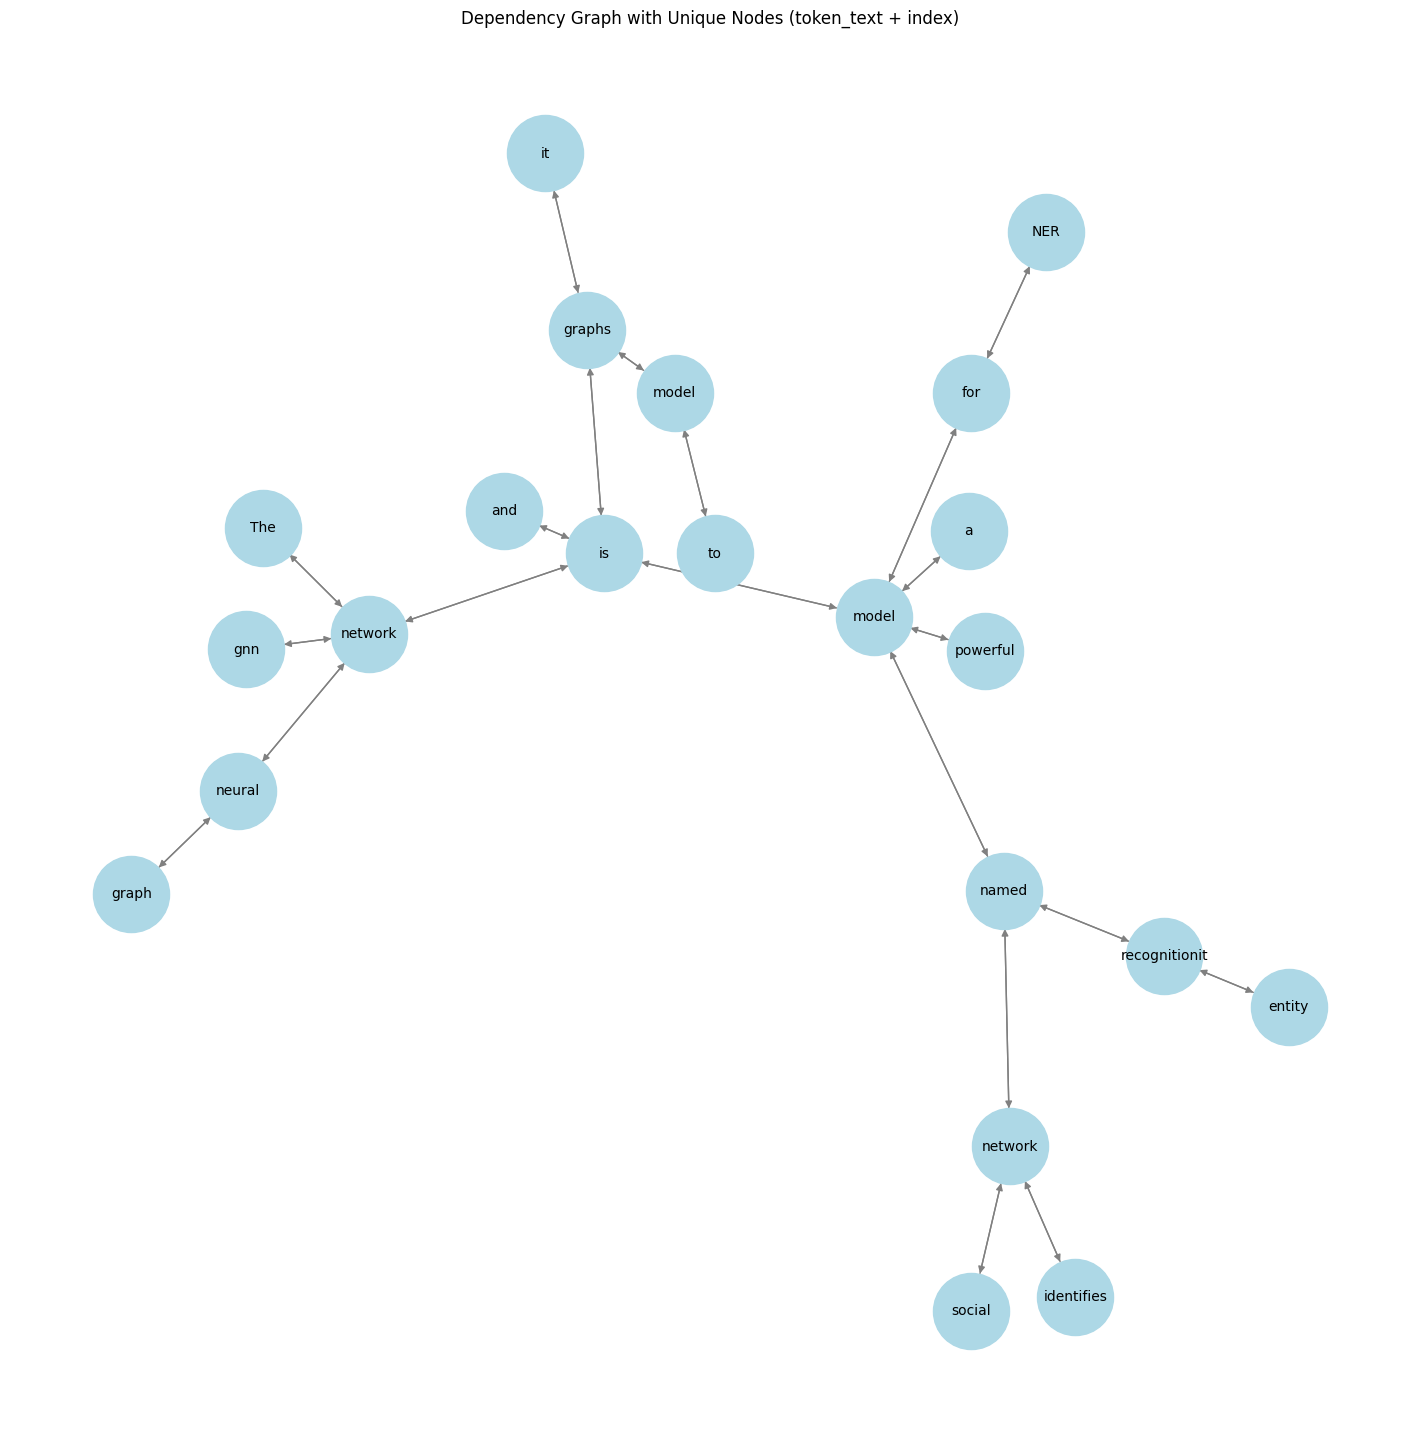

In [37]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Sample sentence
sentence = "The gnn (graph neural network) is a powerful model for NER (named entity recognition).it identifies social network and graphs it to model"
sentence = re.sub(r'[^a-zA-Z0-9\s\']', '', sentence)
doc = nlp(sentence)

# Initialize graph
G = nx.DiGraph()

# Add nodes with unique names using token text + index
for token in doc:
    G.add_node(token.i, label=f"{token.text}")

# Add bidirectional edges based on dependency parse
for token in doc:
    if token.head != token:
        G.add_edge(token.i, token.head.i)       # child → head
        G.add_edge(token.head.i, token.i)       # head → child (optional)

# Visualization
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'label')

plt.figure(figsize=(14, 14))
nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
plt.title("Dependency Graph with Unique Nodes (token_text + index)")
plt.show()


# $$$$$$$$$ CODE OVER $$$$$$$$$$